In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import numpy as np
import os,cv2

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [6]:
import os
import cv2
import numpy as np

dir_name = "/content/drive/MyDrive/dataset/faces/"
y = []
X = []
target_names = []
person_id = 0
h = w = 300
n_samples = 0
class_names = []

# Ensure the base directory exists
if not os.path.exists(dir_name):
    raise FileNotFoundError(f"The directory {dir_name} does not exist.")

# Loop through each person's directory
for person_name in os.listdir(dir_name):
    dir_path = os.path.join(dir_name, person_name)

    # Check if it's a directory
    if os.path.isdir(dir_path):
        class_names.append(person_name)
        for image_name in os.listdir(dir_path):
            image_path = os.path.join(dir_path, image_name)

            # Read the input image
            img = cv2.imread(image_path)

            # Check if the image is loaded properly
            if img is None:
                print(f"Warning: Couldn't load image {image_path}. Skipping.")
                continue

            # Convert into grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize image to 300x300 dimension
            resized_image = cv2.resize(gray, (h, w))

            # Convert matrix to vector
            v = resized_image.flatten()
            X.append(v)

            # Increase the number of samples
            n_samples += 1

            # Adding the categorical label
            y.append(person_id)

            # Adding the person name
            target_names.append(person_name)

        # Increase the person id by 1
        person_id += 1

# Transform list to numpy array
y = np.array(y)
X = np.array(X)
target_names = np.array(target_names)
n_features = X.shape[1]

print(y.shape, X.shape, target_names.shape)
print("Number of samples:", n_samples)

n_classes = len(class_names)

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


(453,) (453, 90000) (453,)
Number of samples: 453
Total dataset size:
n_samples: 453
n_features: 90000
n_classes: 9


Extracting the top 150 eigenfaces from 339 faces


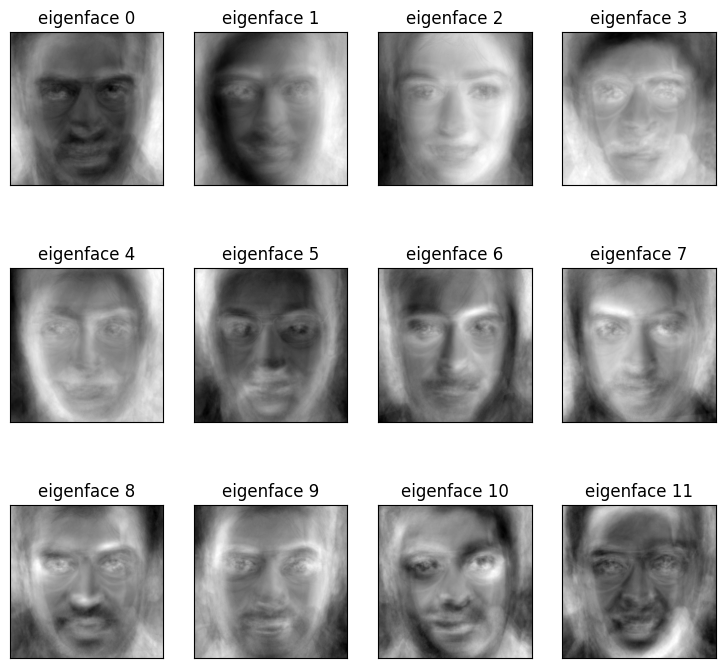

Projecting the input data on the eigenfaces orthonormal basis
(339, 150) (114, 150)
Project done...


In [7]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"% (n_components, X_train.shape[0]))

# Applying PCA
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

# Generating eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape,X_test_pca.shape)

# %%Compute Fisherfaces
lda = LinearDiscriminantAnalysis()
#Compute LDA of reduced data
lda.fit(X_train_pca, y_train)

X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)
print("Project done...")

In [8]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(10, 10),max_iter=1000, verbose=True).fit(X_train_lda, y_train)
print("Model Weights:")
model_info = [coef.shape for coef in clf.coefs_]
print(model_info)

Iteration 1, loss = 2.28931223
Iteration 2, loss = 2.25575157
Iteration 3, loss = 2.22462895
Iteration 4, loss = 2.19414272
Iteration 5, loss = 2.16483249
Iteration 6, loss = 2.13579063
Iteration 7, loss = 2.10863139
Iteration 8, loss = 2.08209521
Iteration 9, loss = 2.05617261
Iteration 10, loss = 2.03110002
Iteration 11, loss = 2.00661985
Iteration 12, loss = 1.98327431
Iteration 13, loss = 1.96036460
Iteration 14, loss = 1.93776733
Iteration 15, loss = 1.91631774
Iteration 16, loss = 1.89458994
Iteration 17, loss = 1.87406482
Iteration 18, loss = 1.85341767
Iteration 19, loss = 1.83339612
Iteration 20, loss = 1.81378734
Iteration 21, loss = 1.79430569
Iteration 22, loss = 1.77477564
Iteration 23, loss = 1.75598758
Iteration 24, loss = 1.73718799
Iteration 25, loss = 1.71855829
Iteration 26, loss = 1.70015240
Iteration 27, loss = 1.68202535
Iteration 28, loss = 1.66407515
Iteration 29, loss = 1.64607499
Iteration 30, loss = 1.62823637
Iteration 31, loss = 1.61110758
Iteration 32, los

Accuracy: 65.78947368421052


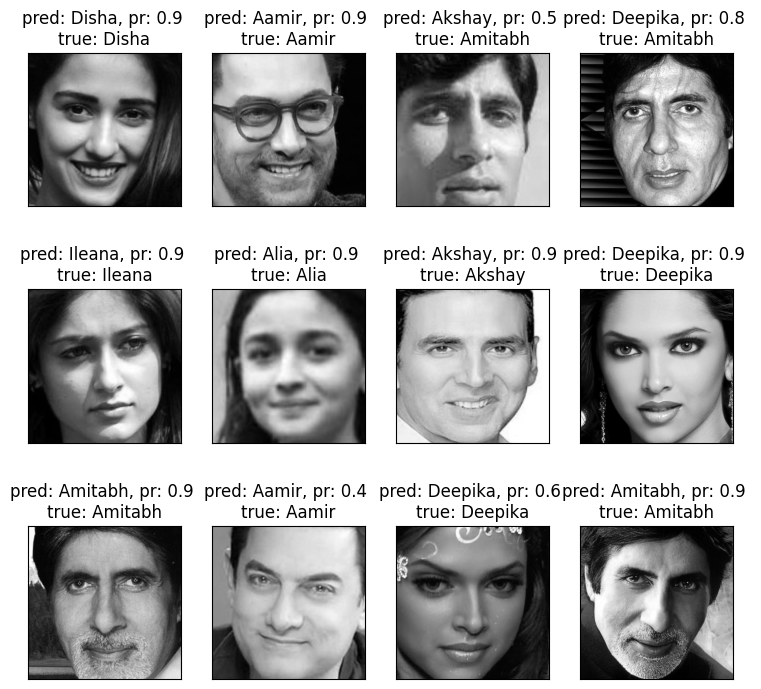

In [9]:
y_pred=[];y_prob=[]
for test_face in X_test_lda:
    prob = clf.predict_proba([test_face])[0]
    # print(prob,np.max(prob))
    class_id = np.where(prob == np.max(prob))[0][0]
    # print(class_index)
    # Find the label of the mathed face
    y_pred.append(class_id)
    y_prob.append(np.max(prob))

# Transform the data
y_pred = np.array(y_pred)


prediction_titles=[]
true_positive = 0
for i in range(y_pred.shape[0]):
    # print(y_test[i],y_pred[i])
    # true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    # pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = class_names[y_test[i]]
    pred_name = class_names[y_pred[i]]
    result = 'pred: %s, pr: %s \ntrue: %s' % (pred_name, str(y_prob[i])[0:3], true_name)
    # result = 'prediction: %s \ntrue:      %s' % (pred_name, true_name)
    prediction_titles.append(result)
    if true_name==pred_name:
        true_positive =true_positive+1

print("Accuracy:",true_positive*100/y_pred.shape[0])

# # Plot results
plot_gallery(X_test, prediction_titles, h, w)
plt.show()